# 作業 : 觀察機器翻譯 ATTENTION 內容 
- 仔細地觀察機器翻譯 ATTENTION 結果

# [作業目標]
- 透過視覺化 注意力 attention 層 了解attention 的作用方式

# [作業重點]
- 透過視覺化 注意力 attention 層 了解attention 的作用方式
- 原則上只要之前的訓練有跑完，這邊的程式可以執行成功最後只要觀察結果就好


In [1]:
import re
import math
import time
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/My Drive/DL_NLP_marathon/data/'
lines = open(data_dir + 'cmn.txt' , encoding='utf-8').read().strip().split('\n')
trnslt_pairs = [[s for s in l.split('\t')] for l in lines ]
print ("Sample:", trnslt_pairs[1000][0:2])
print ("Total records:", len(trnslt_pairs))

Sample: ['He was drowned.', '他被淹死了。']
Total records: 24360


In [4]:
# 下載 spacy 的英文模型 幫我們做tokenize
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# 讀取之前儲存的 vocabulary
model_dir =  '/content/drive/My Drive/DL_NLP_marathon/model/'
cmn_vocab = torch.load(model_dir + 'cmn_vocab.pt')
en_vocab = torch.load(model_dir + 'en_vocab.pt')
print ("中文語料的字元表長度: " , len(cmn_vocab) , ", 英文的字元表長度: " ,len(en_vocab))

中文語料的字元表長度:  2701 , 英文的字元表長度:  4235


In [5]:
def data_process(filepath):
    raw_data = pd.read_csv(filepath, names=['en', 'cmn'])
    data = []
    for (raw_cmn, raw_en) in zip(raw_data['cmn'], raw_data['en']):
        cmn_tensor_ = torch.tensor([cmn_vocab[token] for token in raw_cmn], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long)
        data.append((cmn_tensor_, en_tensor_))
    return data

train_filepath = data_dir + 'train.csv'
val_filepath = data_dir + 'val.csv'
test_filepath = data_dir + 'test.csv'

train_data = data_process(train_filepath)
val_data = data_process(val_filepath)
test_data = data_process(test_filepath)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 512
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

def generate_batch(data_batch):
    en_batch, cmn_batch = [], []
    cmn_lens = []
    for (cmn_item, en_item) in data_batch:
        cmn_seq = torch.cat([torch.tensor([BOS_IDX]), cmn_item, torch.tensor([EOS_IDX])], dim=0)
        cmn_batch.append(cmn_seq)
        cmn_lens.append(len(cmn_seq))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))

    sorted_idx = sorted(range(len(cmn_lens)), key=lambda k: cmn_lens[k], reverse=True)
    cmn_batch = [cmn_batch[i] for i in sorted_idx]
    cmn_lens = torch.tensor([cmn_lens[i] for i in sorted_idx])
    en_batch = [en_batch[i] for i in sorted_idx]
    
    cmn_batch = pad_sequence(cmn_batch, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)

    return (cmn_batch, cmn_lens), en_batch


train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

# 模型主體 和前面範例程式一樣



In [7]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

    def forward(self, dec_input, encoder_outputs, mask):
        # dec_input shape: [1, bz, dec_emb_dim]
        # encoder_outputs shape: [src len, bz, enc_hid_dim x 2]
        # mask  hape: [bz, src len]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        dec_input = dec_input.permute(1,0,2) 
        # dec_input shape: [bz ,1 , dec_emb_dim]

        attention = torch.matmul(dec_input , encoder_outputs.permute(1, 2, 0))
        # [bz ,1 , dec_emb_dim] @ [bz, enc_hid_dim x 2, src len]
        # attention shape: [bz, 1, src len]

        attention = attention.squeeze(1)
        # squeeze bz , src len

        attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention, dim = 1)

In [8]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)  # 雙向 GRU encoder 
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        # src shape: [src len, bz]
        # src_len shape: [ bz ]

        embedded = self.dropout(self.embedding(src))
        # embedded shape [src len, bz, emb dim]
                
        # 使用pack_padded_sequence 來壓縮序列並使用 pad_packed_sequence 用來展開序列成原本形狀
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs shape: [src len, bz, (hid dim * num directions)]
        # hidden shape: [(n layers * num directions), bz, hid dim]
        # hidden 堆疊 [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs 是最後一層 
        
        # hidden [-2, :, : ] 是最後一層 forwards RNN 
        # hidden [-1, :, : ] 是最後一層 backwards RNN
        
        # hidden 是最後再過一層 dense layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        # outputs shape [src len, bz, hid dim * 2]
        # hidden shape [bz, hid dim]
        
        return outputs, hidden

class RNNDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # 單向 GRU decoder 
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):   
        # input shape: [ bz ]
        # hidden shape: [bz, dec hid dim]
        # encoder_outputs shape: [src len, bz, enc hid dim * 2]
        # mask shape: [bz, src len]
        
        input = input.unsqueeze(0)
        #input shape: [1, bz]
        embedded = self.dropout(self.embedding(input))
        #embedded shape: [1, bz, emb dim]
        
        a = self.attention(embedded, encoder_outputs, mask)
        # a shape: [bz, src len]
        a = a.unsqueeze(1)
        # a shape: [bz, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs shape: [bz, src len, enc hid dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted shape: [bz, 1, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted shape: [1, bz, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input shape: [1, bz, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output shape: [seq len, bz, (dec hid dim * n directions)]
        # hidden shape: [(n layers * n directions), bz, dec hid dim]
        
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output shape [1, bz, dec hid dim]
        # hidden shape [1, bz, dec hid dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        # prediction shape: [bz, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2SeqATTN(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        # src shape: [src len, bz]
        # src_len shape: [bz]
        # trg shape: [trg len, bz]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)
        # mask = [bz, src len]
                
        for t in range(1, trg_len):           
            # insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

# 建立模型和重要參數 請保持和前面訓練時一樣

In [9]:
INPUT_DIM = len(cmn_vocab)
OUTPUT_DIM = len(en_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 512
ENC_HID_DIM = 256 # 注意 encoder hidden layer 設定 必須為 dec 的一半 
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = cmn_vocab['<pad>']
TRG_PAD_IDX = en_vocab['<pad>']

LEARNING_RATE = 0.002

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2SeqATTN(enc, dec, SRC_PAD_IDX, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


def initial_mdl_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(initial_mdl_weights)
print ("模型全部參數量: {:10,d} ".format(sum(p.numel() for p in model.parameters())))
model

模型全部參數量: 12,783,499 


Seq2SeqATTN(
  (encoder): RNNEncoder(
    (embedding): Embedding(2701, 256)
    (rnn): GRU(256, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): RNNDecoder(
    (attention): Attention()
    (embedding): Embedding(4235, 512)
    (rnn): GRU(1024, 512)
    (fc_out): Linear(in_features=1536, out_features=4235, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [10]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, src_len = batch[0]
            trg = batch[1]
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, src_len.cpu(), trg, 0) # turn off teacher forcing
            
            # trg shape: [trg len, batch size]
            # output shape: [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            # trg shape: [(trg len - 1) * batch size]
            # output shape: [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [11]:
model_dir =  '/content/drive/My Drive/DL_NLP_marathon/model/'
model.load_state_dict(torch.load(model_dir + 'best-model.pt'))
test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.563 | Test PPL:  35.276 |


In [12]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len = 50):       
    # if isinstance(sentence, str):
    #     en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
    #     tokens = [token.text.lower() for token in en_tokenizer(sentence)]
    # else:
    #     tokens = [token.lower() for token in sentence]

    model.eval()

    tokens = [token.lower() for token in sentence]    
    tokens = ['<bos>'] + tokens + ['<eos>']
        
    src_indexes = [src_vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len.cpu())

    mask = model.create_mask(src_tensor)
    trg_indexes = [trg_vocab['<bos>']]
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break
    
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

# 作業重點
## 請選擇一個好的翻譯結果
## 將其 ATTENTION 視覺化 


In [13]:
# 請在這邊自行調整 sample index 
# 觀察不同句子的 ATTENTION 結果
example_idx = 699

src = [cmn_vocab.itos[idx] for idx in train_data[example_idx][0]]
trg = [en_vocab.itos[idx] for idx in train_data[example_idx][1]]

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, cmn_vocab, en_vocab, model, device)

print(f'predicted trg = {translation}')

src = ['我', '们', '应', '该', '做', '到', '最', '好', '。']
trg = ['We', 'have', 'to', 'do', 'our', 'best', '.']
predicted trg = ['We', 'should', 'have', 'to', 'do', 'that', '.', '<eos>']


In [14]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載字體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
plt.style.use("seaborn-whitegrid")
import matplotlib.ticker as ticker
# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

--2021-05-06 07:54:16--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 108.177.125.100, 108.177.125.102, 108.177.125.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hk8ikhg45f5ndnaof9r40550d4unqp3l/1620287625000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-05-06 07:54:18--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hk8ikhg45f5ndnaof9r40550d4unqp3l/1620287625000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|1

In [15]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
    
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       fontproperties=myfont)
    ax.set_yticklabels(['']+translation, fontproperties=myfont)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

# 請觀察翻譯文 和被翻譯文的語意對應

我们应该做到最好。


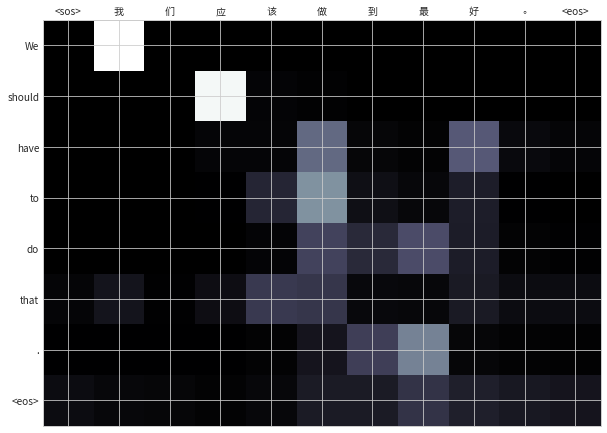

In [16]:
print("".join(src))
display_attention(src, translation, attention)